In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
% matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!wget https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!dpkg -i google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
!apt-get install -f
!apt-get -y install -qq fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


Redirecting output to ‘wget-log.1’.
(Reading database ... 19845 files and directories currently installed.)
Preparing to unpack google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.0-0ubuntu1) over (0.7.0-0ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.0-0ubuntu1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
··········


In [3]:
!mkdir -p drive
!google-drive-ocamlfuse drive

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


In [0]:
X=[]
Z=[]
IMG_SIZE=150
FLOWER_DAISY_DIR='drive/Colab Notebooks/flower recog/flowers/daisy'
FLOWER_SUNFLOWER_DIR='drive/Colab Notebooks/flower recog/flowers/sunflower'
FLOWER_TULIP_DIR='drive/Colab Notebooks/flower recog/flowers/tulip'
FLOWER_DANDI_DIR='drive/Colab Notebooks/flower recog/flowers/dandelion'
FLOWER_ROSE_DIR='drive/Colab Notebooks/flower recog/flowers/rose'


In [0]:
def assign_label(img,flower_type):
    return flower_type
    

In [0]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))
        
        
        

In [7]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 769/769 [00:08<00:00, 94.95it/s] 

769


In [8]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 766/766 [00:07<00:00, 104.83it/s]

1535


In [9]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 991/991 [00:08<00:00, 115.22it/s]

2526


In [10]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(X))

100%|██████████| 1052/1052 [00:09<00:00, 115.29it/s]

3578


In [11]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:06<00:00, 116.18it/s]

4362


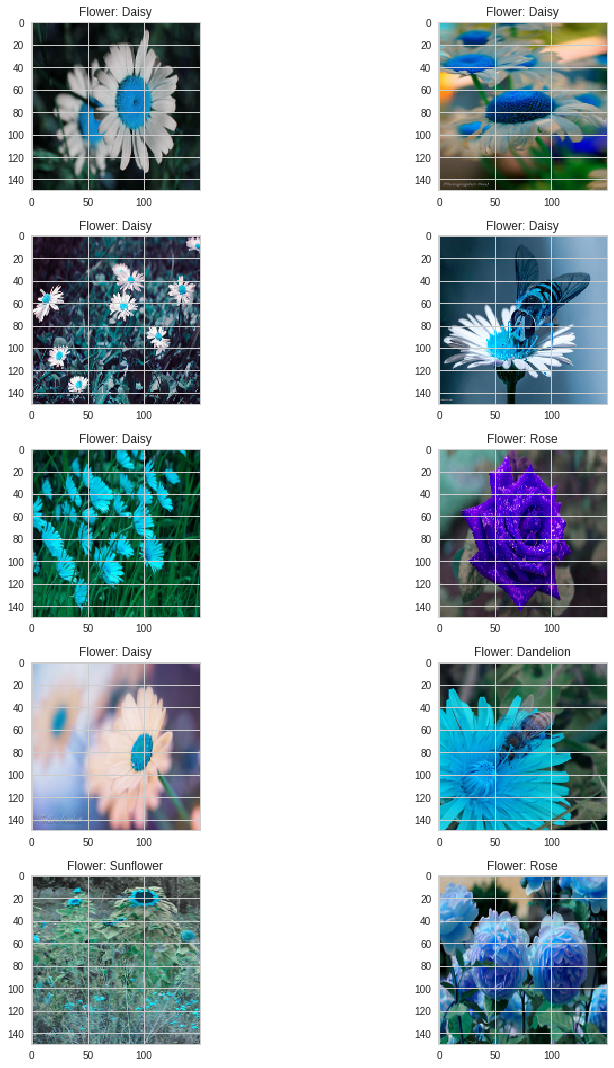

In [12]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()
        

In [0]:
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,5)
X=np.array(X)
X=X/255

In [0]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)


In [0]:
np.random.seed(42)
rn.seed(42)
tf.set_random_seed(42)

In [0]:
base_model=VGG16(include_top=False, weights='imagenet',input_shape=(150,150,3), pooling='avg')

In [40]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5,activation='softmax'))




In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [0]:
epochs=50
batch_size=128

In [44]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1285      
Total params: 14,848,325
Trainable params: 14,847,813
Non-trainable params: 512
_________________________________________________________________


In [0]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
base_model.trainable=False



In [46]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 50, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
25/25 [==============================] - 49s 2s/step - loss: 0.8236 - acc: 0.6898 - val_loss: 0.6347 - val_acc: 0.7864
Epoch 2/50
25/25 [==============================] - 46s 2s/step - loss: 0.4559 - acc: 0.8283 - val_loss: 0.5481 - val_acc: 0.8304
Epoch 3/50
25/25 [==============================] - 46s 2s/step - loss: 0.3290 - acc: 0.8765 - val_loss: 0.4092 - val_acc: 0.8643
Epoch 4/50
25/25 [==============================] - 47s 2s/step - loss: 0.2680 - acc: 0.9056 - val_loss: 0.4290 - val_acc: 0.8653
Epoch 5/50
25/25 [==============================] - 46s 2s/step - loss: 0.2134 - acc: 0.9258 - val_loss: 0.4536 - val_acc: 0.8643
Epoch 6/50
25/25 [==============================] - 46s 2s/step - loss: 0.1926 - acc: 0.9288 - val_loss: 0.4011 - val_acc: 0.8708
Epoch 7/50
25/25 [==============================] - 46s 2s/step - loss: 0.1788 - acc: 0.9379 - val_loss: 0.3227 - val_acc: 0.8900
Epoch 8/50
25/25 [==============================] - 47s 2s/step - loss: 0.1288 - acc: 0.95

In [0]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [0]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

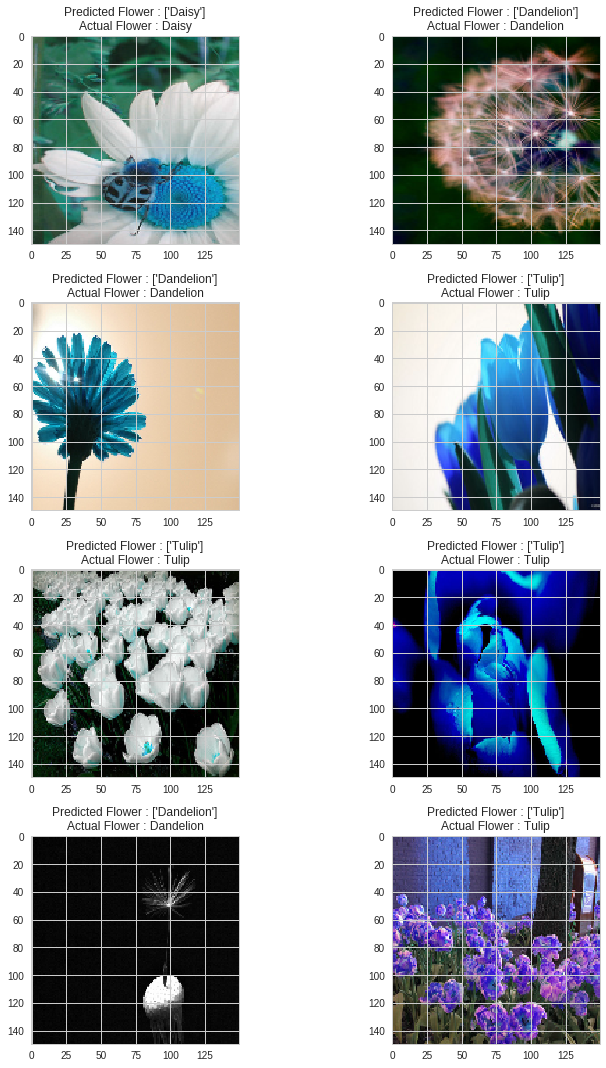

In [51]:
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[prop_class[count]]]))))
        plt.tight_layout()
        count+=1

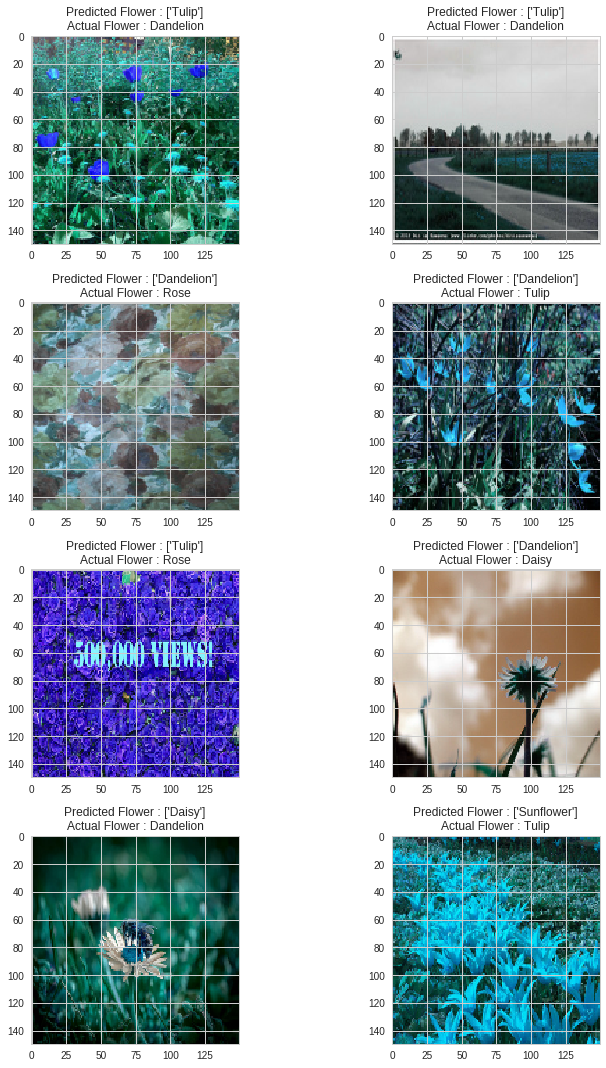

In [52]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform(np.argmax([y_test[mis_class[count]]]))))
        plt.tight_layout()
        count+=1